In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from utils.iterables import all_connectivities

In [9]:
df = pd.read_csv("mesc_thresholded.csv", index_col=0)
df["sorted_pair"] = df.apply(lambda row: tuple(sorted([row['node_a'], row['node_b']])), axis=1)
df= df.drop_duplicates(subset=['sorted_pair', "cluster_label", "fold"])

In [10]:
from itertools import combinations
networks = df.node_a.unique()
stable_msk = (df.cluster_label == 0)
df_scaled = df.copy().loc[~stable_msk]
for net_a, net_b in all_connectivities(networks):
    ref_net_msk = (df.node_a == net_a) & (df.node_b == net_b)
    target_net_msk = (df_scaled.node_a == net_a) & (df_scaled.node_b == net_b)

    ref_value = df[ref_net_msk & stable_msk]["pattern_value"].median()
    df_scaled.loc[target_net_msk, "pattern_value"] -= ref_value
    
    

In [11]:
test_outcome = pd.read_csv("tukeyhsd_blockwise.csv", index_col=0)

In [12]:
net_a

'Vis'

In [13]:
df

,node_a,node_b,pattern_value,cluster_label,fold,sorted_pair
0,Cont,Cont,0.022738,0,0,"(Cont, Cont)"
1,Cont,Default,0.001724,0,0,"(Cont, Default)"
2,Cont,DorsAttn,0.002715,0,0,"(Cont, DorsAttn)"
3,Cont,Limbic,-0.000077,0,0,"(Cont, Limbic)"
4,Cont,SalVentAttn,0.002425,0,0,"(Cont, SalVentAttn)"
...,...,...,...,...,...,...
33,SalVentAttn,SomMot,0.002517,2,7,"(SalVentAttn, SomMot)"
34,SalVentAttn,Vis,-0.000480,2,7,"(SalVentAttn, Vis)"
40,SomMot,SomMot,0.018106,2,7,"(SomMot, SomMot)"
41,SomMot,Vis,0.000368,2,7,"(SomMot, Vis)"


In [14]:
(df.node_a == net_a) & (df.node_b == net_b)

0     False
1     False
2     False
3     False
4     False
      ...  
33    False
34    False
40    False
41    False
48     True
Length: 672, dtype: bool

In [27]:
df

,node_a,node_b,pattern_value,cluster_label,fold,sorted_pair
0,Cont,Cont,0.022738,0,0,"(Cont, Cont)"
1,Cont,Default,0.001724,0,0,"(Cont, Default)"
2,Cont,DorsAttn,0.002715,0,0,"(Cont, DorsAttn)"
3,Cont,Limbic,-0.000077,0,0,"(Cont, Limbic)"
4,Cont,SalVentAttn,0.002425,0,0,"(Cont, SalVentAttn)"
...,...,...,...,...,...,...
33,SalVentAttn,SomMot,0.002517,2,7,"(SalVentAttn, SomMot)"
34,SalVentAttn,Vis,-0.000480,2,7,"(SalVentAttn, Vis)"
40,SomMot,SomMot,0.018106,2,7,"(SomMot, SomMot)"
41,SomMot,Vis,0.000368,2,7,"(SomMot, Vis)"


In [26]:
test_outcome["sorted_pair"] = test_outcome["block_a"]

,column,diff,lwr,upr,p adj,significant,block_a,block_b,clusterlabel_a,clusterlabel_b
1,1:Cont_Cont-0:Cont_Cont,-0.003450,-0.003576,-0.003323,0.000000e+00,True,Cont,Cont,1,0
2,2:Cont_Cont-0:Cont_Cont,-0.003451,-0.003578,-0.003325,0.000000e+00,True,Cont,Cont,2,0
3,2:Cont_Cont-1:Cont_Cont,-0.000001,-0.000128,0.000125,1.000000e+00,False,Cont,Cont,2,1
4,1:Cont_Default-0:Cont_Default,-0.000872,-0.000999,-0.000745,0.000000e+00,True,Cont,Default,1,0
5,2:Cont_Default-0:Cont_Default,-0.000266,-0.000393,-0.000140,1.306177e-12,True,Cont,Default,2,0
...,...,...,...,...,...,...,...,...,...,...
143,2:Vis_SomMot-0:Vis_SomMot,-0.000554,-0.000680,-0.000427,0.000000e+00,True,Vis,SomMot,2,0
144,2:Vis_SomMot-1:Vis_SomMot,0.000235,0.000108,0.000362,4.546918e-12,True,Vis,SomMot,2,1
145,1:Vis_Vis-0:Vis_Vis,-0.008018,-0.008145,-0.007892,0.000000e+00,True,Vis,Vis,1,0
146,2:Vis_Vis-0:Vis_Vis,-0.005507,-0.005634,-0.005380,0.000000e+00,True,Vis,Vis,2,0


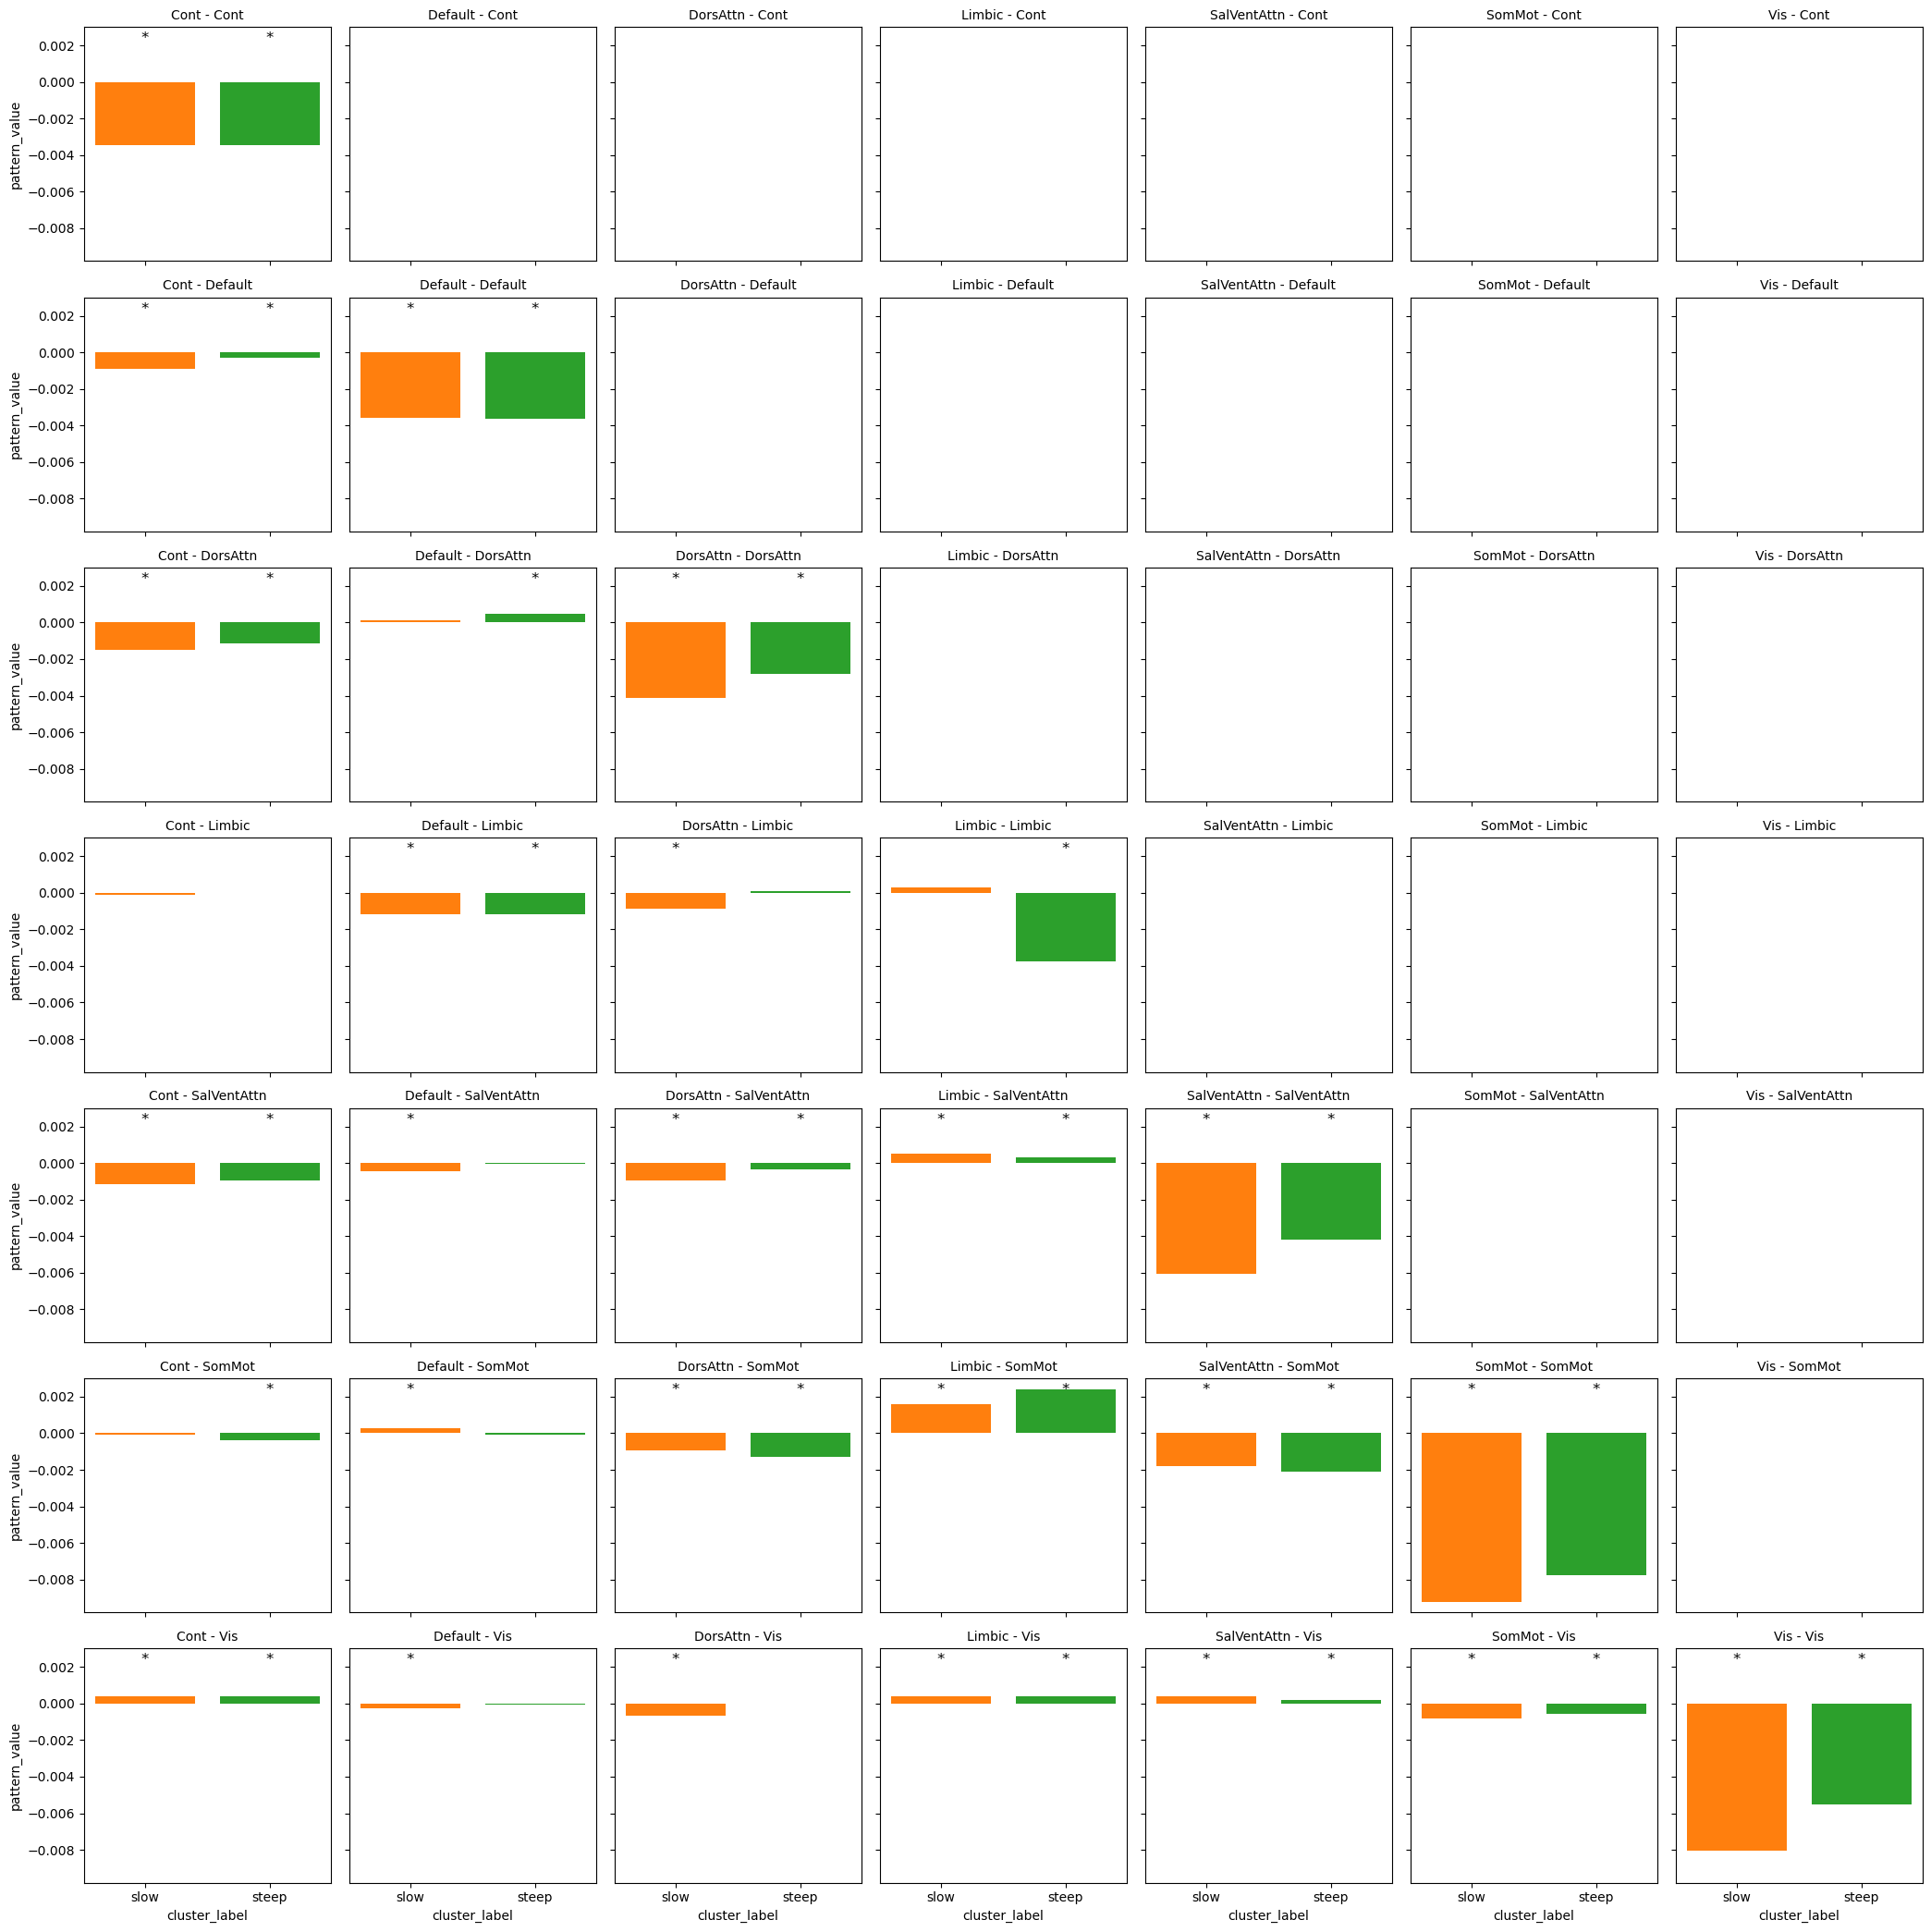

In [15]:
from itertools import product
from math import ceil

grid = sns.FacetGrid(
    df_scaled,
    col="node_a",
    row="node_b",
    hue="cluster_label",
    palette=("tab:orange", "tab:green"),
    margin_titles=False,
    sharex=True,
    sharey=True,
    despine=False,
)
grid.map(plt.bar, "cluster_label", "pattern_value")
grid.set_titles(template="{col_name} - {row_name}")
grid.set(xticks=[1, 2])
grid.set_xticklabels(("slow", "steep"))
y = 0.002

grid_iterator = zip(grid.axes.flat, product(networks, networks))
for ax, (net_a, net_b) in grid_iterator:
    pval = 0.005
    netmask = (test_outcome.block_a == net_a) & (test_outcome.block_b == net_b)
    p_0, p_1, p_2 = test_outcome[netmask]["p adj"].values

    net_key = sorted((net_a, net_b))
    
    y = 0.002
    # TODO Sort test outcomes like df to get max value and debug this
    #y = df[df.sorted_pair.values == net_key].pattern_value.max()
    #y = ceil(y)
    x = 1
    
    for pval in (p_0, p_1):
        if net_a < net_b:
            continue
        if pval < 0.05:
            annotation = "*"
        elif pval < 0.01:
            annotation = "**"
        elif pval < 0.001:
            annotation = "***"
        else:
            annotation = ""

        ax.text(x, y, annotation, ha="center", va="bottom", fontsize=12, color="black")
        x += 1


In [16]:
decliners = sns.color_palette("tab10")[1:3]

In [17]:
intranet_msk = (df_scaled.node_a == df_scaled.node_b)
df_scaled[intranet_msk]

,node_a,node_b,pattern_value,cluster_label,fold,sorted_pair
0,Cont,Cont,-0.003396,1,0,"(Cont, Cont)"
8,Default,Default,-0.003548,1,0,"(Default, Default)"
16,DorsAttn,DorsAttn,-0.004061,1,0,"(DorsAttn, DorsAttn)"
24,Limbic,Limbic,0.000314,1,0,"(Limbic, Limbic)"
32,SalVentAttn,SalVentAttn,-0.005998,1,0,"(SalVentAttn, SalVentAttn)"
...,...,...,...,...,...,...
16,DorsAttn,DorsAttn,-0.002827,2,7,"(DorsAttn, DorsAttn)"
24,Limbic,Limbic,-0.003752,2,7,"(Limbic, Limbic)"
32,SalVentAttn,SalVentAttn,-0.004199,2,7,"(SalVentAttn, SalVentAttn)"
40,SomMot,SomMot,-0.007781,2,7,"(SomMot, SomMot)"


Text(0.5, 1.0, 'Aggregated Pattern differences')

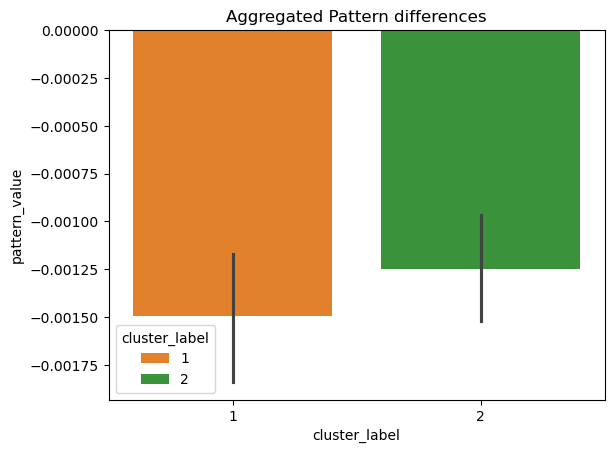

In [18]:
sns.barplot(df_scaled, x="cluster_label", y="pattern_value", hue="cluster_label", palette=decliners)
plt.title("Aggregated Pattern differences")

In [19]:
df_scaled

,node_a,node_b,pattern_value,cluster_label,fold,sorted_pair
0,Cont,Cont,-0.003396,1,0,"(Cont, Cont)"
1,Cont,Default,-0.000883,1,0,"(Cont, Default)"
2,Cont,DorsAttn,-0.001497,1,0,"(Cont, DorsAttn)"
3,Cont,Limbic,-0.000122,1,0,"(Cont, Limbic)"
4,Cont,SalVentAttn,-0.001098,1,0,"(Cont, SalVentAttn)"
...,...,...,...,...,...,...
33,SalVentAttn,SomMot,-0.002123,2,7,"(SalVentAttn, SomMot)"
34,SalVentAttn,Vis,0.000188,2,7,"(SalVentAttn, Vis)"
40,SomMot,SomMot,-0.007781,2,7,"(SomMot, SomMot)"
41,SomMot,Vis,-0.000550,2,7,"(SomMot, Vis)"


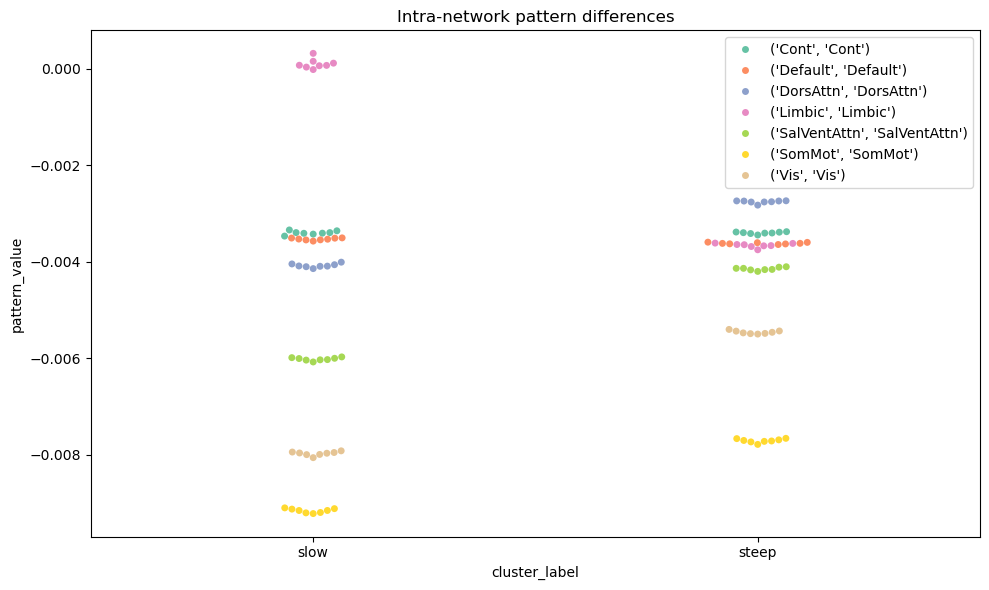

In [20]:
plt.subplots(figsize=(10, 6))
sns.swarmplot(df_scaled[intranet_msk], x="cluster_label", y="pattern_value", hue="sorted_pair", palette="Set2")
plt.title("Intra-network pattern differences")
plt.xticks(ticks=[0, 1], labels=["slow", "steep"])
plt.tight_layout()
plt.legend(loc="upper right")

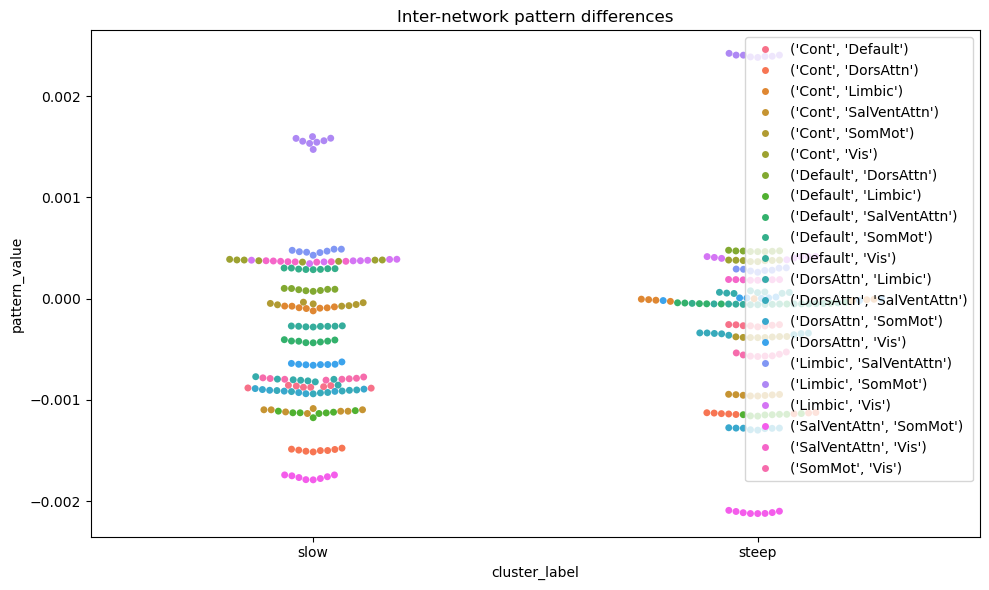

In [21]:
plt.subplots(figsize=(10, 6))
sns.swarmplot(df_scaled[~intranet_msk], x="cluster_label", y="pattern_value", hue="sorted_pair")
plt.title("Inter-network pattern differences")
plt.xticks(ticks=[0, 1], labels=["slow", "steep"])
plt.tight_layout()
plt.legend(loc="upper right")

Text(0.5, 1.0, 'Inter-network pattern differences')

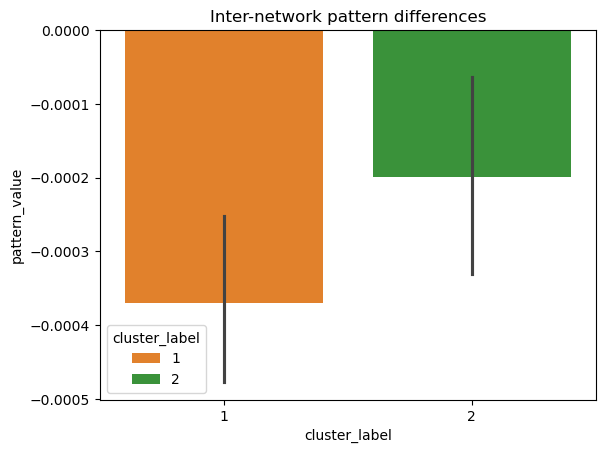

In [22]:
sns.barplot(df_scaled[~intranet_msk], x="cluster_label", y="pattern_value", hue="cluster_label", palette=decliners)
plt.title("Inter-network pattern differences")